# Tutorial for *CYCLUS*: Nuclear Fuel Cycle Simulator 

<img src="img/cyclus_img.gif" width="400">
## [*CYCLUS*](http://fuelcycle.org/) Introduction
*CYCLUS* is an open source nuclear fuel cycle simulation platform whose  genesis was driven by a variety of gaps seen in previous fuel cycle simulation efforts, which attempted to address three major design and development philosophies:
- A desire for usability, thus developing a tool which begins with a simple model in a visual development environment that aims to provide an intuitive user interface
- A desire for rapid prototyping, thus developing a tool which begins with simple models in a scripting language that allows for quick answers to early problems 
- A desire for detail/fidelity, thus developing a tool with an ad-hoc combination of existing complex analysis tools 

http://fuelcycle.org/basics/index.html


## Fundamental Concepts in Cyclus
Several fundamental concepts are deeply engrained in the Cyclus kernel, and understanding them is important for users and developers of Cyclus.

The following concepts are defined in more detail below:
   - Cyclus is an agent-based simulation
   - agents are either regions, institutions, or facilities
   - Cyclus tracks the evolution of a system over time
   - agents interact through a dynamic resource exchange that is recomputed at each time step
   - Cyclus catalogs the transactions of discrete quanta of resources
   - agents may enter or leave the simulation over the lifetime of a simulation
   - each agent is deployed as a clone of a prototype
   - each prototype is defined as a configuration an archetype
   - archetypes are loaded dynamically at runtime and can be contributed by any user/developer

### Agent-Simulation

A Cyclus simulation models a system of discrete agents that interact to exchange resources. Most of the behavior of a Cyclus simulation is the result of the interaction among a set of individual and nominally independent agents

### Region, Institution, Facility Hierarchy¶
The primary agent interaction is among Facility agents, each representing a single discrete nuclear fuel cycle facility.

Each Facility agent is owned/operated by an Institution agent, representing a legal operating organization such as a utility, government, non-governmental organization, etc. Institution agents are responsible for deploying and decommissioning Facility agents.

Each Institution operates in a Region agent, representing a geopolitical region such as a nation-state, sub-national state, super-national region, etc. Region agents are responsible for requesting the deployment of additional Facilities through their Institutions.

Institution and Region agents can alter the way that their Facility agents interact with other Facility agents.
Through the use of agents and its user-customizable archetypes (called prototypes), cyclus  allows for freedom in fidelity, depth, and focus of the simulation.

### Tracking the Fuel Cycle Over Time¶

A Cyclus simulation marches through time with a fixed time step. At each time step, the system itself may change and the dynamic resource exchange is recomputed.

### Agent Deployment and Decommissioning¶

Facility agents can be deployed or decommissioned at each time step, changing the system that is being modeled through the dynamic resource exchange. The decision of when to deploy new facility agents and which agents to deploy is made by the institution agents based on user input. Agents may be decommissioned either because they reach their lifetime or because a decision to decommission is made by the institution that operates them.
### Agent Prototypes¶
Each agent in the simulation is deployed as a clone of a prototype. A prototype is formed by adding user-defined configuration details to an archetype.
### Agent Archetypes
Agent archetypes define the logic that governs the behavior of an agent. An archetype may allow a user to define some parameters that influence that behavior. Broadly speaking, the behavior of an agent can be divided into the behavior that represents the physical models of the system and the behavior that represents the interaction of the agent with other agents.
### Run-time Discovery and Loading of Archetypes
To maximize the flexibility of the Cyclus infrastructure, is has been designed to allow the addition of new archetypes without having to make any changes to the Cyclus kernel. Therefore, the kernel has no prior knowledge of archetypes or their behavior other than how they are deployed/decommissioned and how they interact with the dynamic resource exchange. For this reason, every Cyclus simulation must find and load the archetypes requested by the user.


### Dynamic Resource Exchange¶
Facility agents interact through the dynamic resource exchange by submitting requests for resources and/or receiving bids to provide those resources. All facilities that request resources can then establish their preferences across the set of bids they receive and the global set of preferences is used to resolve the exchange by maximizing the global preference.

### Discrete Resource Tracking¶
The outcome of the dynamic resource exchange is a set of transactions of discrete resources, with specific quantities and identities, between specific facility agents. These discrete resources can be tracked through their life cycle by their identities.


❖ **Learning Objectives**

-   Principles of *CYCLUS* input files
-   Writing a *CYCLUS* input file 
-   Use *CYCLUS* to simulate your input file
-   Utilize cyutils (*CYCLUS* analysis package) to analyze the *CYCLUS* output file

# Table of contents
- How to build a *CYCLUS* input file
    - Simulation Control
    - Fuel Composition
    - Region
    - Reactor
    - Main Input 
- Exercise 1: Writing the Input file 
    - Simulation Control
    - Fuel Composition
    - Region
    - Reactor
    - Main Input 
- Exercise 2: Running the *CYCLUS* simulation

# How to build a *CYCLUS* input file

This tutorial will begin with a simple exercise using Cycamore archetypes to familiarize the user with [creating input files](http://fuelcycle.org/user/writing_input.html)(in xml) and accessing data from the SQLite database output.  This tutorial is not an [exhaustive list](http://fuelcycle.org/user/index.html) of ways to do these things, but it should give new users a good starting point.

## Structure of a CYCLUS input file






# Excerise 1
### Developing a *CYCLUS* input file:
This first exercise will model a very simple scenario:
-  There is a single uranium mine
-  One enrichment facility producing UOX fuel
-  One LWR, with a 1000 MWe capacity
-  One repository, which takes SNF
-  This is an open fuel cycle, there is no reprocessing or MOX fuel.
<br/><br/>

\begin{gather*} 
\textrm{Uranium Mine} \xrightarrow{\textrm{Natural Uranium}} \textrm{Enrichment Facility} \xrightarrow{\textrm{Fresh UOX Fuel}} \textrm{Reactor} \xrightarrow{\textrm{Spent Nuclear Fuel}} \textrm{Repository}
\end{gather*} 

<div class="alert alert-warning">
**Programming**
<br/><br/>
Throughout this tutorial, there will be cells of code mixed into the explanations.  Some of these will need information entered before they are run - a comment at the beginning of the cell will tell you.  If you are unfamiliar with Jupyter notebook, you can run a cell by selecting it, and using shift+enter or ctrl+enter (selected cells will have a blue or green line around them).  Please do not run all cells at once.
</div>

To begin, let's import the necesary packages.

In [1]:
from pyne import nucname
import cyutils
from cyutils import analysis
from cyutils import write
from cyutils import economics
import matplotlib.pyplot as plt
import numpy as np
from numpy import isclose

Usage: python write_input.py [csv][init_date] [duration] [output_file_name]


### How Cyclus Works
Let's begin by choosing our simulation parameters.

*CYCLUS* works in timesteps of 1 month by default.  At each time step, *CYCLUS* has phases in which each agent can take particular actions:
-  [Deployment](http://fuelcycle.org/basics/concepts.html?highlight=deployed#agent-deployment-and-decommissioning): New agents may enter the system
-  Each agent prepares for material exchange
-  The material trade occurs
-  The agents act after the exchange
-  [Decommissioning](http://fuelcycle.org/basics/concepts.html?highlight=decommissioned#agent-deployment-and-decommissioning): Agents may leave the system
<br><br>

*CYCLUS* will manage these phases automatically, but the user must give:
-  The duration (in months)
-  The start month (e.g.: 1 for January)
-  The start year
-  [Decay](http://fuelcycle.org/devdoc/decay.html):  'never' if all decay is turned off, 'manual', meaning it is only on if the individual archetype decays their own inventory, or 'lazy', which will compute decay only when archetypes fetch a particular composition.
<br>
There are other [optional parameters](http://fuelcycle.org/user/input_specs/control.html) that could be given, but these are the ones we will use during the tutorial.
<br>
### What needs to go into a cyclus input file 
#### region, recipe, ... IMAGE

For this exercise, the simuation will run for 60 years, or 720 months.  We'll model a system that starts in January, 2018.  Decay will be set to 'never' for now.

The lifetime of a *CYCLUS* simulation is determined by its **`duration`**. **`duration`** is the number of months *CYCLUS* will model the fuel cycle. *CYCLUS* also intakes the **`start_month`** and **`start_year`** of the simulation. 
The last major parameter of the simulation is whether or not we wish to model the **[`decay`](http://fuelcycle.org/devdoc/decay.html)** of the radioactive elements (uranium ore, nuclear fuel, & spent nuclear fuel) in the simulation. For simplicity, we will not model decay in this tutorial. 

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `duration`      | `720`  | length of simulation (months) |
| `start_month`      | `1` | start month of simulation |
| `start_year`     | `2018` | start year of simulation |
| `decay`   | `'never'`  | radioactive decay |


In [2]:
'''
Initialize all variables given from the table.
'''
duration = 720 # length of simulation (months)
start_month = 1 # start month of simulation
start_year = 2018 # start year of simulation
decay = 'never' # radioactive decay

simulation_parameters = [duration,start_month,start_year,decay]

In [3]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert type(duration)    == int and duration    == 720
assert type(start_month)    == int and start_month    == 1
assert type(start_year)   == int   and start_year   == 2018
assert type(decay) == str and decay == 'never'
print('Success!')

Success!


### Archetypes:
One of the features of *CYCLUS* is its ability to switch between different models of the facilities within the fuel cycle.  These models, called **archetypes**, may change how the facility interacts with other facilities or how the physics of the facility are represented.
<br><br>
For example, reactor archetypes change how the reactor experiences fuel burnup and its fresh and spent fuel compostions. A very simple reactor archetypes might only input the reactors fuel recipes and their compositions. A more complex model may tabulate reactor performance and physics parameters, and interpolate its input and output recipes. The most complex model could perform a full depletion calculation each time new fuel enters the reactor.
<br><br>
A simple set of archetypes have been created in [Cycamore](http://fuelcycle.org/user/cycamoreagents.html).  They are a good fit for simple tutorials, or for modeling facilities that are required, but not the focus of the simulation.  The Cycamore archetypes include:
-  [Source](http://fuelcycle.org/user/cycamoreagents.html?highlight=source#cycamore-source): This is a generic source of fresh material.  This could be an uranium mine, an enrichment facility, or even a fabrication facility, depending on how explicitly the user wants to model the front-end of the fuel cycle.
-  [Enrichment](http://fuelcycle.org/user/cycamoreagents.html?highlight=enrichment#cycamore-enrichment): This archetype uses the standard equations for enrichment of U-235, and has a limit on total enrichment capacity.
-  [Reactor](http://fuelcycle.org/user/cycamoreagents.html?highlight=reactor#cycamore-reactor): This facility takes set input and output fuel recipes, and loads new assemblies at regular intervals.
-  [Separations](http://fuelcycle.org/user/cycamoreagents.html?highlight=separations#cycamore-separations): This facility splits all the isotopes in its input stream into separate output streams.
-  [FuelFab](http://fuelcycle.org/user/cycamoreagents.html?highlight=fuelfab#cycamore-fuelfab): This archetype uses the d-factor approach to mix streams of fissile and fissionable material and approximate a given recipe.
-  [Sink](http://fuelcycle.org/user/cycamoreagents.html?highlight=sink#cycamore-sink):  This is a generic sink for any facility that will permanently hold nuclear material.  This could be an interim storage facility, a geological repository, or other long-term disposal methods a user may want to model.

When you customize or specify the details of an archetype, that is referred to as a **prototype**.

# Add mention making own archetype 
## Cyborg
## Brightlite
## Recycle


### Commodities:

*CYCLUS* models resource transactions through the use of the [dynamic resource exchange](http://fuelcycle.org/arche/dre.html), or DRE.  A [commodity](http://fuelcycle.org/user/input_specs/commodity.html) simply defines a resource that agents in the simulation may want to exchange with each other.  For example, spent fuel would be a commodity that leaves a reactor facility, and then is "exchanged" with a repository to simulate its final disposal.  Defining a commodity gives no information about its composition - that is done by defining [recipes](fuelcycle.org/user/input_specs/recipe.html).
#### Tracking commodities: 
- tracking truckloads... diversion 

\begin{gather*} \textrm{Reactor} \end{gather*} | | \begin{gather*} \textrm{Spent Fuel} \end{gather*}| |\begin{gather*} \textrm{Repository} \end{gather*}
:-------------------------:|:----:|:-------------------------:
<img src="img/nuclear_reactor.png" width="300"> | \begin{gather*} \xrightarrow{} \end{gather*} | <img src="img/nuclear_waste.jpg" width="150"> | \begin{gather*} \xrightarrow{} \end{gather*} |  <img src="img/nuclear_repository.png" width="300">
<br>


<div class="alert alert-warning">
**A Note On Input Files**
<br/>

There are multiple ways to create a *CYCLUS* input file.  This tutorial uses the jinja2 template library and .xml templates to create its input.  More detail will be given later, but for now, know that some parts of the archetypes (such as the name of the enrichment facility) are already included in the templates provided for the tutorial.  Beyond this lesson, it is possible to use or create other templates and tweak these "preloaded" details. </div>

### Creating recipes:

Whenever *CYCLUS* needs to know the composition of a material, it looks at the recipe for that material given in the input file.  Until now, "recipe" has been used to refer to fuel recipes, but the "recipe" section of the input file can include the recipe for natural uranium, spent fuel, fresh fuel, or any other material where the isotopic composition needs to be tracked.
<br><br>
First, we can declare the isotopic compostions of fresh and spent fuel.  We'll be using simple recipes: fresh fuel is 4.0% U-235 by mass, remainder U-238.  Spent fuel is 1.1% U-235, 94.0% U-238, 0.9% Pu-239, and 4.0% Cs-137.

\begin{gather*} 
\textrm{Enrichment Facility} \xrightarrow{\textrm{4.0% Enriched Uranium}} \textrm{Reactor} \xrightarrow{\textrm{Spent Nuclear Fuel}} \textrm{Repository}
\end{gather*} 
<br>

\begin{gather*} \textrm{Fresh Nuclear Fuel} \end{gather*} | \begin{gather*} \textrm{Reactor} \end{gather*}| \begin{gather*} \textrm{Spent Nuclear Fuel} \end{gather*}
:-------------------------:|:----:|:-------------------------:
<img src="img/powder_pellet.jpg" width="150"> | \begin{gather*} \xrightarrow{} \end{gather*}  |  <img src="img/nuclear_waste.jpg" width="150">
<br>

\begin{gather*} 
\textrm{Fresh Fuel Compostition}
\end{gather*} 

| Nuclide | Mass composition |
| ------- | --------- |
| $^{235}$U | 4.0 % |
| $^{238}$U | 96.0 % |

\begin{gather*} 
\textrm{Spent Fuel Compostition}
\end{gather*} 

| Nuclide | Mass composition |
| ------- | --------- |
| $^{239}$Pu | 0.9% |
| $^{235}$U | 1.1% % |
| $^{137}$Cs | 4.0% |
| $^{238}$U | 94.0 % |



In [4]:
fresh_id = [92235,92238]
fresh_comp = [0.04, 0.96]

spent_id = [92235, 92238, 94239, 55137]
spent_comp = [0.011, 0.94, 0.009, 0.04]

We will take the fresh and spent ids and compostitions above and use the recipe function to create a fuel recipe. 


In [5]:
fresh,spent = write.recipe(fresh_id,fresh_comp,spent_id,spent_comp)
print(fresh)
print(spent)

{92235: 0.04, 92238: 0.96}
{92235: 0.011, 92238: 0.94, 94239: 0.009, 55137: 0.04}


<div class="alert alert-warning">
**Fuel Recipe Note**
<br/>
The recipe for natural uranium has already been included in the template.
</div>


<div class="alert alert-warning">
**Providing Reactor Data Recipe Note**
<br/>
<font size='2'>For the purposes of the tutorial, we'll input reactor information here in the notebook, then render it into a csv file and import it again.  Obviously, this isn't needed - we could directly input our reactor data and never bother with external files.  However, we're including this step to help new users who may be unfamiliar with python with one of many ways to import external data.</font>
</div>
<br>

Exercise 1 models a single PWR.  It has a power capacity of 1000 MWe, and there is only one of them in the region.  Using the table below, fill in the missing information.

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `country`      | `'United States'`  | country of reactor |
| `reactor_name`      | `'1178MWe BRAIDWOOD-1'` | name of reactor |
| `type_reactor`     | `'PWR'` | type of reactor |
| `net_elec_capacity`   | `1178`  | net electric capacity (MWe) |
| `operator`   | `'Exelon'`  | operator of reactor |




In [6]:
'''
Initialize all variables given from the table.
'''
country = 'United States' # country of reactor
reactor_name = 'BRAIDWOOD-1' # name of reactor
type_reactor = 'PWR' # type of reactor
net_elec_capacity = 1178 #net electric capacity (MWe)
operator = 'Exelon' #operator of reactor

In [7]:
# your code should pass these tests---do NOT edit this cell
assert type(country)    == str and country    == 'United States'
assert type(reactor_name)    == str and reactor_name    == 'BRAIDWOOD-1'
assert type(type_reactor)   == str   and type_reactor   == 'PWR'
assert type(net_elec_capacity) == int and net_elec_capacity == 1178
assert type(operator) == str and operator == 'Exelon'

print('Success!')

Success!


Now using analysis.write, we will write this data into a csv file called "tutorial_data.csv".

In [8]:
header = ['Country','Reactor Name','Type','Net Electric Capacity','Operator'] # this is the header of our csv file
raw_input = [country,reactor_name,type_reactor,net_elec_capacity,operator] # this is the data we will be inserting into the csv file
filename = "single_reactor_data.csv" # this is the filename of the csv file 

write.write_csv(header,raw_input, filename)

Within the reactor data, we gave how many reactors were initially deployed.  However, we still need to set how many mines, enrichment facilities, and repositories are in our region.  For now, we'll say that there is one of each facility in our region.

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `n_mine`      | 1  | number of mines |
| `n_enrichment`      | 1 | number of enrichment facilities |
| `n_repository`     | 1 | number of repositories |


In [9]:
n_mine = 1 # number of mines
n_enrichment = 1 # number of enrichment facilities
n_repository = 1 #number of repositories


In [10]:
# your code should pass these tests---do NOT edit this cell
assert type(n_mine)    == int and n_mine    == 1
assert type(n_enrichment)    == int and n_enrichment    == 1
assert type(n_repository)   == int   and n_repository   == 1

print('Success!')

Success!


### Rendering the Input File:

In practice, your simulation may have more variables, and you may be pulling data from external databases.  But, for this tutorial, we are ready to render the main input file for *CYCLUS*. <br>First, we'll import our "external data"  from a csv file with the information we gave earlier:

In [11]:
# This cell does not need user input, and you can run it now.

reactor_data = write.import_csv('single_reactor_data.csv')
reactor_data

,Country,Reactor Name,Type,Net Electric Capacity,Operator
0,United States,BRAIDWOOD-1,PWR,1178,Exelon


In [12]:
deployment_data = {}
for element in reactor_data.loc[:,'Country'].drop_duplicates():
    deployment_data[element] = [n_mine,n_enrichment,n_repository]
        
print(deployment_data)

{'United States': [1, 1, 1]}


The input file is created in parts - it is common to have separate, smaller templates for the reactor, the recipes, and other blocks of the input file that require many variables.
# Take out print outs (Put in highlighted pictures)


| Template | | Data  || Input |
| -------- | | ------|| ------- |
| $\boxed{\textrm{Reactor Template}}$   | + | $\boxed{\textrm{Reactor Data}}$ | = | $\boxed{\textrm{Reactor Input}}$ |
| $\boxed{\textrm{Region Template}}$    | + | $\boxed{\textrm{Region Data}}$ | = | $\boxed{\textrm{Region Input}}$ |
| $\boxed{\textrm{Recipe Template}}$    | + | $\boxed{\textrm{Recipe Data}}$ | = | $\boxed{\textrm{Recipe Input}}$ |
<br><br>
Let's start by taking a look at the reactor template.
#### Reactor Template

In [13]:
with open('template/reactor_template.xml','r') as reactor:
    print(reactor.read())

<facility>
  <name>{{capacity}}MWe {{reactor_name}}</name>
  <config>
    <Reactor>
      <fuel_incommods> <val>fresh-uox</val> </fuel_incommods>
      <fuel_inrecipes> <val>fresh-uox</val> </fuel_inrecipes>
      <fuel_outcommods> <val>spent-uox</val> </fuel_outcommods>
      <fuel_outrecipes> <val>spent-uox</val> </fuel_outrecipes>
      <cycle_time>18</cycle_time>
      <refuel_time>1</refuel_time>
      <assem_size>{{assem_size}}</assem_size>
      <n_assem_core>{{n_assem_core}}</n_assem_core>
      <n_assem_batch>{{n_assem_batch}}</n_assem_batch>
      <power_cap>{{capacity}}</power_cap>
    </Reactor>
  </config>
</facility>



The facility tree holds all the information about a specific prototype. For example in the reactor template above we can see the fuel_in commodity and recipe as fresh-uox and the fuel_out ommodity and recipe as spent-uox. 

There are facility trees for each prototype made - the mine, the enrichment facility, and repository.
<br><br>
You may notice that some values had been replaced by something in {{ }}.  The template will recognize these as variables.  We can also take a look at the region, recipe, and main templates.
#### Region Template

In [14]:
with open('template/region_template.xml','r') as region:
    print(region.read())


{% for country, operator in country_reactor_dict.items() -%}
{% for operators, reactors in operator.items() -%}
<region>
  <name>{{country}} {{operators}} Reactors</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      {% for reactor_name, reactor_info in reactors.items() -%}
      <entry>
        <prototype>{{reactor_info[1]}}MWe {{reactor_name}}</prototype>
        <number>{{reactor_info[0]}}</number>
      </entry>
      {% endfor -%}
    </initialfacilitylist>
    <name>{{operators}} in {{country}}</name>
    <config>
      <NullInst/>
    </config>
  </institution>
</region>

{% endfor -%}
{% endfor -%}


{% for country, deploy in countries_infra.items() -%}
<region>
  <name>{{country}} Infrastructure</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      <entry>
        <prototype>UraniumMine</prototype>
        <number>{{deploy[0]}}</number>
      </entry>
      <entry>
        <prototype>Enrichme

Within the region and recipe template, you will see `{% for x,y in z.items() -%} ... {% endfor -%}`.  These are for loops, and work similarly to for loops in other languages.  For each element in x,y (note that in both templates, we might more accurately say that the loops are {% for key, value in dicitionary.items() -%}, as in this specific instance, the input-rendering functions use dictionaries.) it copies whatever is between the {%-%} {% -%} brackets, and fills in the variables in the designated locations.

#### Recipe Template

In [15]:
with open('template/recipe_template.xml','r') as recipe:
    print(recipe.read())

<recipe>
  <name>nat-u</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.00711</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.99289</comp>
  </nuclide>
</recipe>

<recipe>
  <name>fresh-uox</name>
  <basis>mass</basis>
  {% for key, value in fresh_fuel.items() -%}
  <nuclide>
    <id>{{key}}</id>
    <comp>{{value}}</comp>
  </nuclide>
  {% endfor -%}
</recipe>

<recipe>
  <name>spent-uox</name>
  <basis>mass</basis>
  {% for key, value in spent_fuel.items() -%}
  <nuclide>
    <id>{{key}}</id>
    <comp>{{value}}</comp>
  </nuclide>
  {% endfor -%}
</recipe>



### Writing the fuel recipe
For example, in the recipe template above, the for loop in the fresh fuel recipe block will make a new nuclide block for each isotope in the fresh_fuel dicitionary.  To see this in action, we can simply render the recipe portion:

In [16]:
rendered_recipe = write.write_recipes(fresh,spent,'template/recipe_template.xml','1xn-rendered-recipe.xml')

with open(rendered_recipe,'r') as recipe:
    print(recipe.read())

<recipe>
  <name>nat-u</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.00711</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.99289</comp>
  </nuclide>
</recipe>

<recipe>
  <name>fresh-uox</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.04</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.96</comp>
  </nuclide>
  </recipe>

<recipe>
  <name>spent-uox</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.011</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.94</comp>
  </nuclide>
  <nuclide>
    <id>94239</id>
    <comp>0.009</comp>
  </nuclide>
  <nuclide>
    <id>55137</id>
    <comp>0.04</comp>
  </nuclide>
  </recipe>


As you can see, within the fresh fuel recipe there are now two nuclide blocks, one for each isotope in the fresh dictionary we made earlier.<br><br>
#### Main input Template
We can also look at the main input template.  In order to insert the already rendered parts into the main input file, it has {{variable}} sections where each section would go.  Then, in a fashion simiar to how the templates have been opened here in the notebook, the files are assigned to variables and inserted into the template.

In [17]:
with open('template/main_input.xml','r') as main:
    print(main.read())

<simulation>
  <control>
    <duration>{{duration}}</duration>
    <startmonth>{{start_month}}</startmonth>
    <startyear>{{start_year}}</startyear>
    <decay>{{decay}}</decay>
  </control>

  <archetypes>
    <spec>
      <lib>cycamore</lib>
      <name>Enrichment</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Reactor</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Source</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Sink</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullRegion</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullInst</name>
    </spec>
  </archetypes>

  <commodity>
    <name>u-ore</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>fresh-uox</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>tails</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <

As seen above, there are facility trees for each prototype made - the mine, the enrichment facility, and repository. all have their own section within the main input, as well as sections for setting simulation parameters, and defining archetypes and commodities.

### Creating the Input File
Now, let's actually create the input file.  The recipe portion was made earlier, so the only the reactor, region, and main input remains.
### Writing the reactor recipe

In [18]:
rendered_reactor = write.write_reactor(reactor_data, 'template/reactor_template.xml','template/1xn-rendered-reactor.xml')
with open(rendered_reactor,'r') as reactor:
    print(reactor.read())

<facility>
  <name>1178MWe BRAIDWOOD-1</name>
  <config>
    <Reactor>
      <fuel_incommods> <val>fresh-uox</val> </fuel_incommods>
      <fuel_inrecipes> <val>fresh-uox</val> </fuel_inrecipes>
      <fuel_outcommods> <val>spent-uox</val> </fuel_outcommods>
      <fuel_outrecipes> <val>spent-uox</val> </fuel_outrecipes>
      <cycle_time>18</cycle_time>
      <refuel_time>1</refuel_time>
      <assem_size>33000</assem_size>
      <n_assem_core>3</n_assem_core>
      <n_assem_batch>1</n_assem_batch>
      <power_cap>1178</power_cap>
    </Reactor>
  </config>
</facility>


rendered_region = write.write_region(reactor_data,deployment_data,'template/region_template.xml','template/1xn-rendered-region.xml')
with open(rendered_region,'r') as region:
    print(region.read())
  
<br><br>   
<img src="img/colorcodet5.png" width="600">

### Writing the region recipe


### Writing the main input


In [20]:
write.write_main_input(simulation_parameters,rendered_reactor,rendered_region,rendered_recipe,
                 'main_input.xml','1xn-rendered-main-input.xml')
with open('1xn-rendered-main-input.xml','r') as maininput:
    print(maininput.read())

<simulation>
  <control>
    <duration>720</duration>
    <startmonth>1</startmonth>
    <startyear>2018</startyear>
    <decay>never</decay>
  </control>

  <archetypes>
    <spec>
      <lib>cycamore</lib>
      <name>Enrichment</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Reactor</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Source</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Sink</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullRegion</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullInst</name>
    </spec>
  </archetypes>

  <commodity>
    <name>u-ore</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>fresh-uox</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>tails</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>spent-uox</name>
    <solution_p

It is possible to change some of the variables in this input file to suit user preference.  However, certain names used in one scetion must match the names used in others.  For reference, an image of an input file has been included below, with the parts that must match each other highlighted in matching colors.
<br><br>
<img src="img/colorcodet1.png" width="600">
<img src="img/colorcodet2.png" width="600">
<img src="img/colorcodet3.png" width="600">
<img src="img/colorcodet4.png" width="600">
<img src="img/colorcodet5.png" width="600">
<img src="img/colorcodet6.png" width="600">

# Excerise 2
### Running the Simulation:
*CYCLUS* can be run using a single terminal command, given below. The cell will run this command for you, but it's also possible to remove the ! and directly run it in the terminal

In [21]:
# CYCLUS will not overwrite an old file - delete the old version if you run a simulation again and put
# the output to the same filename
!rm singlereactortutorial.sqlite
!cyclus 1xn-rendered-main-input.xml -o singlereactortutorial.sqlite
# this is a command that can be executed in your terminal, without the ! . The -o flag is used to
# set the name of the output file.  Without it, the default is "cyclus.sqlite"

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   


Status: Cyclus run successful!
Output location: singlereactortutorial.sqlite
Simulation ID: d04349f1-4c43-4c15-8a84-636c8c3bd1df


# Exercise 3
### Analyze the results:

*CYCLUS* creates a .sqlite file as its output.  SQL is a database file type that consists of a series of tables.  A few functions have been included in cyutils.analysis.py to pull information from the sqlite database and create figures.<br><br>
An sqlite database can be opened and its contents viewed, but these database browsers often aren't helpful. Importing the data into an external function and manipulating it would provide more useful information. However, it can still be helpful to open and view the tables.
<img src="img/Selection_002.png" width="650"><br><br>
This a view of the tables within the database (using DB browser for SQLite).  However, to view the data within these tables, switch to the Browse Data tab:<br>
<img src="img/Selection_003.png" width="650"><br>
And select the table of interest.  Some tables have data that may need to be manipulated or used alongside other data in other tables, which is why using a python script is often ideal.

First, a cursor that points to the sqlite file is created:

In [22]:
cur = analysis.cursor('singlereactortutorial.sqlite')

#### Total mass traded

How much $^{235}$U left the 1178MWe BRAIDWOOD-1?
To find out, lets use the `total_isotope_traded` function!
The `total_isotope_traded` takes three input arguments:
- cur (cursor to *CYCLUS* output file)
- facility (facility of interest)
- flux (direction of isotope transaction)
- nucid (nuclide id)

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `cur`      | `cur` | cursor to *CYCLUS* output file |
| `facility`      | `'1178MWe BRAIDWOOD-1'` | facility of interest |
| `flux`      | `'out'` | isotope transaction direction |
| `nucid`      | `922350000` | nuclide id |


In [23]:
cur = cur # cursor to CYCLUS output file
facility = '1178MWe BRAIDWOOD-1' # facility of interest
flux = 'out' # isotope transaction direction
nucid = 922350000 # nuclide id 
print('Total amount of U235 that left the '+ str(facility) +' reactor:')  
analysis.total_isotope_traded(cur,facility,flux,nucid)

Total amount of U235 that left the 1178MWe BRAIDWOOD-1 reactor:


13431.0

Now let's plot the cumulative mass of the spent nuclear fuel that is taken out of the 1178MWe BRAIDWOOD-1.
Again, let's use the handy `analysis.plot_out_flux_cumulative`function which takes input arguments:
- cur (cursor to *CYCLUS* output file)
- facility (facility of interest)
- title (title of plot)

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `cur`      | `cur` | cursor to *CYCLUS* output file |
| `facility`      | `'1178MWe BRAIDWOOD-1'` | facility of interest |
| `title`      | `'Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1'` | title of plot |


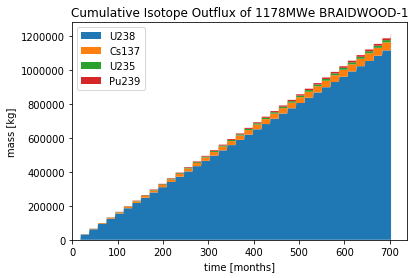

In [24]:
facility = '1178MWe BRAIDWOOD-1'
title = 'Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1'
analysis.plot_out_flux_cumulative(cur, facility,title)

Let's take a look at the total mass of spent nuclear fuel stored at the Nuclear Waste Repository.
To plot, use the `analysis.plot_in_flux_cumulative(cur, facility, title)` function. 
<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `facility`      | `'NuclearRepository'` | facility of interest |
| `title`     | `'Cumulative Isotope Inventory of Repository'` | title of plot |


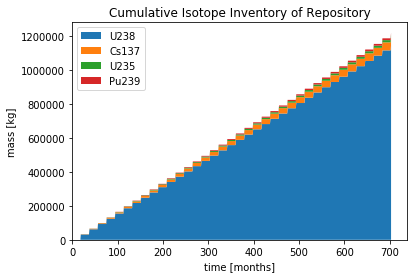

In [25]:
facility = 'NuclearRepository' # facility of interest
title  = 'Cumulative Isotope Inventory of Repository'  # title of plot

analysis.plot_in_flux_cumulative(cur, facility,title)

Now let's plot the cumulative mass of the spent nuclear fuel that is mined from the Uranium mine.
To plot the outflux of a facility, use the analysis.plot_out_flux_cumulative(cur,sender,plot title) function.

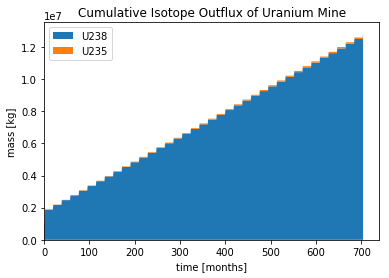

In [26]:
analysis.plot_out_flux_cumulative(cur, 'UraniumMine','Cumulative Isotope Outflux of Uranium Mine')


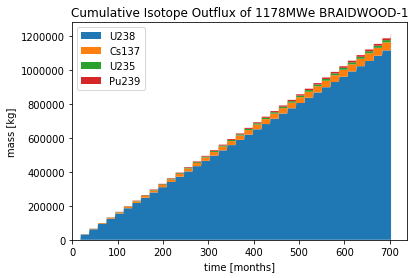

In [27]:
analysis.plot_out_flux_cumulative(cur, '1178MWe BRAIDWOOD-1','Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1')

Now let's plot the mass series and cumulative mass of the fresh nuclear fuel that is received by the of the 1178MWe BRAIDWOOD-1.

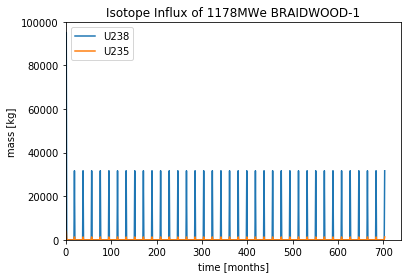

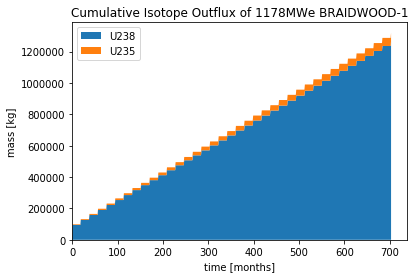

In [28]:
analysis.plot_in_flux(cur, '1178MWe BRAIDWOOD-1','Isotope Influx of 1178MWe BRAIDWOOD-1')
analysis.plot_in_flux_cumulative(cur, '1178MWe BRAIDWOOD-1','Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1')

In cyclus, facilities are defined by their `prototype_id`. For example if the simualtion had 20 different reactors, we could still find a certain one via its `prototype_id`.

<div class="alert alert-info">
**Interactive Input**
<br/>
In the cell below use type `facility = 'UraniumMine'` and then run the cell.
</div>

In [29]:
facility = 'UraniumMine'
print('The prototype_ids for' + ' ' + facility + ' ' +'' + 'are:')
analysis.prototype_id(cur, facility)

The prototype_ids for UraniumMine are:


['25']

We can also find the total amount [kg] of an isotope that was used/sent from a facility using the `total_isotope_used` function.
For example, if we wanted to find out how much $^{235}$U and $^{238}$U was mined from the Uranium Mine, we can call:

In [30]:
uranium_mined = analysis.total_isotope_used(cur, 'UraniumMine')
print("Total amount of U-235 mined:" + ' '  + str(uranium_mined['U235']) + ' ' + 'kg')
print("Total amount of U-238 mined:" + ' '  + str(uranium_mined['U238']) + ' ' + 'kg')


Total amount of U-235 mined: 91599.6350365 kg
Total amount of U-238 mined: 12791612.0438 kg


Let's say we wanted to see the composition of the spent nuclear fuel from the reactor. We could call `total_isotope_used` with `facility` = `'1178MWe BRAIDWOOD-1'` to find out!

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variable.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `facility`      | `'1178MWe BRAIDWOOD-1'` | facility of interest |


Text(0.5,1,'SNF mass composition')

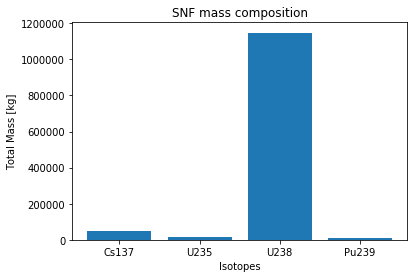

In [31]:
facility = '1178MWe BRAIDWOOD-1' # facility of interest
snf_comp = analysis.total_isotope_used(cur, facility)
snf_comp
isotopes = [item[0] for item in snf_comp.items()]
masses = [item[1] for item in snf_comp.items()]
plt.bar(isotopes,masses)
plt.xlabel('Isotopes')
plt.ylabel('Total Mass [kg]')
plt.title('SNF mass composition')

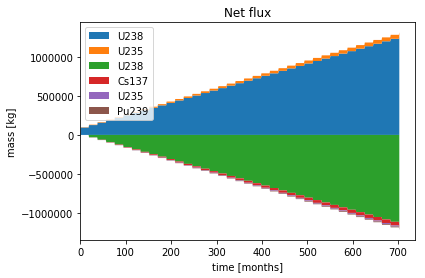

In [32]:
analysis.plot_net_flux_cumulative(cur,'1178MWe BRAIDWOOD-1','Net flux')


In [33]:
analysis.u_util_calc(cur)

array([  0.00000000e+00,   1.68220504e-21,   1.68220504e-21,
         1.68220504e-21,   1.68220504e-21,   1.68220504e-21,
         1.68220504e-21,   1.68220504e-21,   1.68220504e-21,
         1.68220504e-21,   1.68220504e-21,   1.68220504e-21,
         1.68220504e-21,   1.68220504e-21,   1.68220504e-21,
         1.68220504e-21,   1.68220504e-21,   1.68220504e-21,
         1.68220504e-21,   2.24294005e-21,   2.24294005e-21,
         2.24294005e-21,   2.24294005e-21,   2.24294005e-21,
         2.24294005e-21,   2.24294005e-21,   2.24294005e-21,
         2.24294005e-21,   2.24294005e-21,   2.24294005e-21,
         2.24294005e-21,   2.24294005e-21,   2.24294005e-21,
         2.24294005e-21,   2.24294005e-21,   2.24294005e-21,
         2.24294005e-21,   2.24294005e-21,   2.80367506e-21,
         2.80367506e-21,   2.80367506e-21,   2.80367506e-21,
         2.80367506e-21,   2.80367506e-21,   2.80367506e-21,
         2.80367506e-21,   2.80367506e-21,   2.80367506e-21,
         2.80367506e-21,

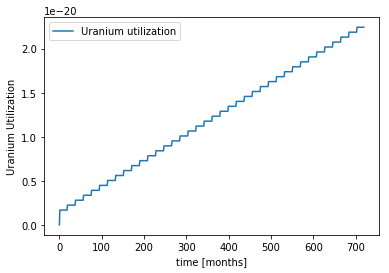

In [34]:
analysis.plot_uranium_utilization(cur)


## Decay heat
Using our `spent` fuel composition from above, lets see which isotope causes the most decay heat!

/Users/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


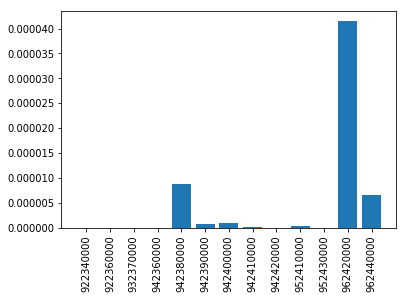

In [35]:
from pyne import data
from pyne.material import Material

data.decay_const('u238')

snf = analysis.total_isotope_used(cur,facility='1178MWe BRAIDWOOD-1')
snf_mass = np.sum(list(snf.values()))

lwr_snf_ma = Material(spent,snf_mass)
lwr_snf_ma = Material({'U234': 0.12, 
                    'U236': 4.18,
                    'Np237': 0.75,
                    '236Pu': 9.2E-6,
                    '238Pu': 0.22,
                    '239Pu': 5.28,
                    '240Pu': 2.17,
                    '241Pu': 1.02,
                    '242Pu': 0.35,
                    '241Am': 0.05,
                    '243Am': 0.09,
                    '242Cm': 4.9E-3,
                    '244Cm': 3.3E-2},
                   1000)

#print(snf_ma.comp)
#print(lwr_snf_ma.activity())
#print(lwr_snf_ma.decay_heat())
D=lwr_snf_ma.decay_heat()

import matplotlib.pylab as plt
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys(), rotation='vertical')

plt.show()



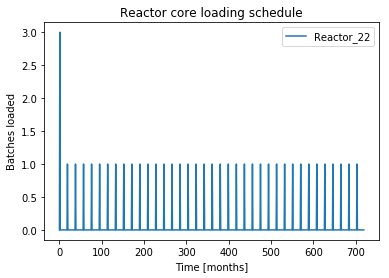

In [37]:
analysis.plot_reactor_events(cur,reactors = [])
